# Inversion of Gravity Gradiometry Data on a Tree Mesh

We use the PGI module within SimPEG to invert gravity gradiometry data on a Tree Mesh. This tutorial focusses on:

    - How to define all the necessary components
    - How to initialize the Gaussian Mixture Model Prior
    - How to set the parameters
    - How to plot the results

## Import Modules

In [101]:
import discretize as ds
import SimPEG.potential_fields as pf
from SimPEG import (
    maps,
    data,
    utils,
    simulation,
    inverse_problem,
    inversion,
    optimization,
    regularization,
    data_misfit,
    directives,
)
from SimPEG.utils import io_utils
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import matplotlib as mpl
import matplotlib.pyplot as plt
import math as math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
from discretize import TensorMesh, TreeMesh
from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG import maps
from SimPEG.potential_fields import magnetics as mag
from SimPEG.potential_fields import gravity as grav
import os
import shutil
import SimpegHelper as SH

#from get_cpt import get_cmap

# Plot beautification

formatter = mpl.ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((0,0)) 

mpl.rc("axes", titlesize=14, labelsize=12)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Reproducible science
np.random.seed(518936)

# Create directories for the model iterations and output

In [102]:
# Name of the model
name = "Ireland_FTG_NonNeg"
# Names for the directories for the model iterations and output
path_to_mod_iterations = "./" + str(name) + "/Model Iterations"
path_to_output = "./" + str(name) + "/Output"

# Check if the model iterations directory exists and remove it if it does
if os.path.exists(path_to_mod_iterations):
    shutil.rmtree(path_to_mod_iterations)

# Create the model iterations directory.
os.makedirs(path_to_mod_iterations)

# Check if the output directory exists and remove it if it does
if os.path.exists(path_to_output):
    shutil.rmtree(path_to_output)

# Create the output directory.
os.makedirs(path_to_output)

## Load the data

In [103]:
# Read gravity and magnetic data from a csv file.
# Inputs:
# file_path: The path to the csv file.
# header: Whether or not the csv file has a header row.

file_path = 'Ireland_FTG_Gridded.csv'
header = None

# Read the csv file into a pandas dataframe and then convert it to a numpy array.
FTG_Data = pd.read_csv(file_path, delimiter=",").to_numpy()

# Add Topography
FTG_Data = np.c_[FTG_Data, np.zeros(np.shape(FTG_Data)[0])]
FTG_Data[:,[2, -1]] = FTG_Data[:,[-1, 2]]

# Format after adding topography
# X, Y, Z, Tyy, Txz, Tyz, Txy, Txx

## Resample the data

The ``SimpegHelper.pf_rs()`` will take in potential field data and resample it onto a new regular grid

In [104]:
# New sampling interval (Data Units)
inc = 200

# Resample the data
[grav_new, nx_new, ny_new] = SH.pf_rs(FTG_Data, inc)

# Extract the gravity gradiometry data vectors
grav_vec = grav_new[:,3:]

# Negate the gravity data to the opposite sign to match the coordinate system.
# NOTE: This step is necessary for real data since the convention followed by
# the SimPEG forward operator gravity lows over density highs.
# grav_vec = -grav_vec

# Extract the topography for the active cells.
inv_topo = grav_new[:,[0,1,2]]

## Visualize the data

The ``SimpegHelper.plot_2D_data()`` function will plot the datasets using ``matplotlib``.

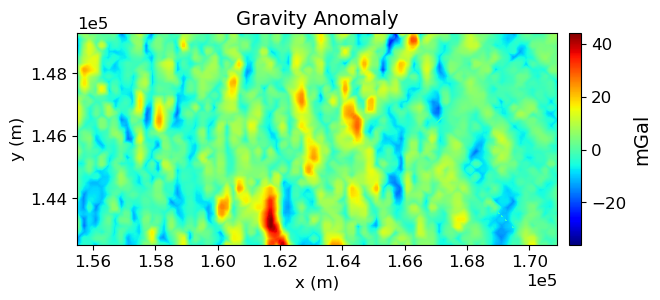

In [105]:
# Plot Gravity Data
SH.plot_2D_data(np.c_[grav_new[:,[0,1,2]], grav_vec[:,-1]], [np.nanmin(grav_vec[:,-1]), np.nanmax(grav_vec[:,-1])], cmap="jet", path_to_output=path_to_output, name=name)

# Plot Topography Data
# SH.plot_2D_data(np.c_[inv_topo[:,[0,1,2]], inv_topo[:,2]], [np.nanmin(inv_topo[:,2]), np.nanmax(inv_topo[:,2])], which_data="Topo", cmap="magma", path_to_output=path_to_output, name=name)

## Create a TreeMesh object to invert the data

Using the ``discretize.TreeMesh`` utility, create a 3D TreeMesh to invert the gravity gradiometry data.

In [106]:
dx = inc
dy = inc
dz = 10
nz_core = 1
nz_pad = 20
fact = 1.1

# Set the cell sizes to a constant value in the x and y directions and expanding in the z direction.
inv_hx = dx * np.ones(nx_new)
inv_hy = dy * np.ones(ny_new)
inv_hz = [(dz, nz_pad, -fact), (dz, nz_core), (dz, nz_pad, fact)]

# Create the inverse tensor mesh.
inv_mesh = ds.TensorMesh([inv_hx, inv_hy, inv_hz], x0=[np.min(inv_topo[:,0]), np.min(inv_topo[:,1]), "C"])

# Drape the topography over the mesh
actv = active_from_xyz(inv_mesh, inv_topo)
ndv = np.nan
actvMap = maps.InjectActiveCells(inv_mesh, actv, ndv)
nactv = int(actv.sum())

# Make an x-y grid with the mesh cell centers
# xygrid = np.meshgrid(inv_mesh.cell_centers_x, inv_mesh.cell_centers_y)
# xygrid = np.reshape(xygrid, (2,-1)).T

# Region Active Array (bool array with the spatial extent of the data)
# RegActvArr = np.empty((len(xygrid)), dtype=bool)

# for i in range(len(xygrid)):
#     Dist = np.sqrt(np.sum((inv_topo[:, [0, 1]] - xygrid[i,:])**2, axis=1))
#     MinDist = np.min(Dist)
#     RegActvArr[i] = MinDist < 50

# Repeating the regional active array for every z (since we only carried out the calculations for x-y, which can be replicated in z)
# RegActvArr = np.tile(RegActvArr, len(inv_mesh.cell_centers_z))

# Intersection between Topo active cells and spatial active cells (nactv and actvMap are also updated)
actv = actv
nactv = int(actv.sum())
actvMap = maps.InjectActiveCells(inv_mesh, actv, ndv)

In [107]:
inv_mesh

TensorMesh: 111,930 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     78    155,500.00    171,100.00    200.00    200.00    1.00
   y     35    142,500.00    149,500.00    200.00    200.00    1.00
   z     41       -635.02        635.02     10.00     67.27    1.10

## Visualize the mesh

The ``discretize.TreeMesh.plot_slice()`` utility will plot a slice of thee Tree Mesh object generated above.

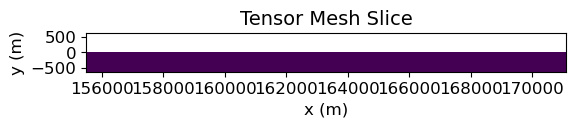

In [108]:
# Plotting a mesh slice
# Create a background model.
bg = np.ones(nactv)
mod = actvMap * bg

# Define the tensor mesh parameters.
props = dict(boxstyle='round,pad=1', facecolor='white')

# Plot the mesh slice.
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
cplot = inv_mesh.plot_slice(mod, grid=False, ax=ax, normal="Y", ind=22)
ax.set_title('Tensor Mesh Slice')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.ticklabel_format(axis="both")
ax.set_aspect('equal')
plt.savefig(path_to_output + "/" + name + "_TreeMeshSlice.pdf", bbox_inches="tight")
plt.show()

## Set up the gravity inverse problem

In [109]:
# Create wires for the density model
wires = maps.Wires(("density", nactv))

# Create a Density Mapping
density_map = actvMap * wires.density
# Create Identity Mapping
identity_map = maps.IdentityMap(nP=nactv)

# Components of the data used as input
gravity_components = ["gyy", "gxz", "gyz", "gxy", "gxx"]

# Receiver locations
gravity_receiver_locations = grav_new[:, [0, 1, 2]]

# Create a gravity receiver list
gravity_receivers = pf.gravity.receivers.Point(gravity_receiver_locations, components=gravity_components)
gravity_receiver_list = [gravity_receivers]

# Create a gravity source field
gravity_source_field = pf.gravity.sources.SourceField(receiver_list=gravity_receiver_list)

# Define the gravity survey
gravity_survey = pf.gravity.survey.Survey(gravity_source_field)

# Set up the gravity simulation problem
gravity_problem = grav.simulation.Simulation3DIntegral(
    inv_mesh, 
    survey=gravity_survey, 
    rhoMap=wires.density, 
    ind_active=actv
)

# Define uncertainties
# Maximum value of each component
# max_gravity = np.max(np.abs(grav_vec), axis=0)
# Standard deviation of each component
# std_gravity = 0.05 * max_gravity
# std_gravity = np.ones(np.shape(grav_vec)) * std_gravity

# Create a gravity data object
gravity_data = data.Data(gravity_survey, dobs=grav_vec.flatten(), noise_floor=5, relative_error=0.1)

# Define the misfits associated with the gravity data
gravity_misfit = data_misfit.L2DataMisfit(data=gravity_data, simulation=gravity_problem)

## Set up the Gaussian Mixture Model (GMM) Prior

In [110]:
# Defining the Gaussian Mixture Model (GMM)
# Number of rock units and number of physical properties
num_rock_units = 5
num_physical_props = 1

# Create a weighted Gaussian mixture model with specified parameters
gmmref = utils.WeightedGaussianMixture(
    n_components=num_rock_units,
    mesh=inv_mesh,
    actv=actv,
    covariance_type="full",
)

# Set the background density
background_density = 0.0

# Initialize the GMM fit with random samples, mesh size, and number of physical properties
gmmref.fit(np.random.randn(nactv, num_physical_props))

# Set the mean values of physical property contrasts for each rock unit
# One value (density) for each rock unit
gmmref.means_ = np.c_[
    [-0.4],
    [-0.2],
    [0.0],
    [0.2],
    [0.4],
].T

# Set the original variance for density
density_variance = 8e-5

# Set the covariances of physical properties for each rock unit
gmmref.covariances_ = np.array(
    [
        [[density_variance]],
        [[density_variance]],
        [[density_variance]],
        [[density_variance]],
        [[density_variance]]
    ]
)

# Compute the precision (inverse covariance) of each cluster
gmmref.compute_clusters_precisions()

# Set the weights for each rock unit
gmmref.weights_ = np.ones((nactv, 1)) * np.c_[0.125, 0.125, 0.5, 0.125, 0.125]

<Figure size 600x600 with 0 Axes>

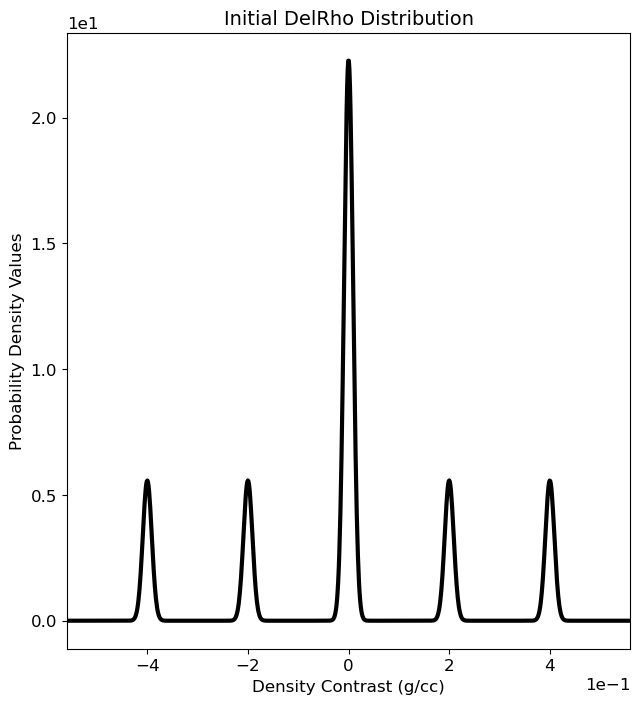

In [111]:
# GMM Parameters
means_init = gmmref.means_.flatten()
covariances_init = gmmref.covariances_.flatten()
weights_init = gmmref.weights_[0].flatten()

# Plot the 1D GMM
fig = plt.figure(figsize=(6, 6))
ax = gmmref.plot_pdf(flag2d=False, plotting_precision=1000, padding=0.2)
ax[0].set_xlabel(r"Density Contrast (g/cc)")
ax[0].set_ylabel(r"Probability Density Values")
ax[0].get_legend().remove()
ax[0].set_title(r"Initial DelRho Distribution")
ax[0].ticklabel_format(axis="both", style="scientific", scilimits=(0, 0))
ax[0].set_aspect(1/20)
plt.savefig(path_to_output + "/" + name + "_Init_GMM.pdf", bbox_inches="tight")
plt.show()

## Define the inversion parameters

In [112]:
# Initial Model
initial_model = np.r_[background_density * np.ones(actvMap.nP)]

# Sensitivity weighting
# Compute the sensitivity weights for each cell based on the gravity problem's sensitivity matrix (G)
# This is done by computing the square root of the sum of the squared elements of G for each cell,
# and then normalizing by the cell volumes and the maximum weight value.
sensitivity_weights_gravity = np.sum(gravity_problem.G ** 2.0, axis=0) ** 0.5 / (inv_mesh.cell_volumes[actv])
sensitivity_weights_gravity = sensitivity_weights_gravity / np.nanmax(sensitivity_weights_gravity)

# Regularization multipliers
smallness_multiplier = 1e-4
smoothness_x_multiplier = 1e-1
smoothness_y_multiplier = 1e-1
smoothness_z_multiplier = 1e-1

# Create joint PGI regularization with smoothness
regularization_term = regularization.PGI(
    gmmref=gmmref,
    mesh=inv_mesh,
    wiresmap=wires,
    maplist=[identity_map],
    active_cells=actv,
    alpha_pgi=smallness_multiplier,
    alpha_x=smoothness_x_multiplier,
    alpha_y=smoothness_y_multiplier,
    alpha_z=smoothness_z_multiplier,
    alpha_xx=0.0,
    alpha_yy=0.0,
    alpha_zz=0.0,
    weights_list=[sensitivity_weights_gravity]
)

# Directives for inversion
# Define the directives for the inversion process, based on Astic et al., (2021)

# Estimate smoothness multipliers
alphas_directive = directives.AlphasSmoothEstimate_ByEig(verbose=True)

# Initialize beta and beta/alpha_s schedule
beta_directive = directives.BetaEstimate_ByEig(beta0_ratio=1e-2)
beta_schedule = directives.PGI_BetaAlphaSchedule(
    coolingFactor=16.0,
    tolerance=0.2,
    progress=0.2,
    verbose=True,
)

# Define target misfits for geophysical and petrophysical data
target_misfits = directives.MultiTargetMisfits(verbose=True)

# Add reference model once stable
mref_in_smooth = directives.PGI_AddMrefInSmooth(wait_till_stable=True, verbose=True)

# Update smallness parameters, keeping GMM fixed (L2 Approx of PGI)
update_smallness_directive = directives.PGI_UpdateParameters(
    update_gmm=True,
    kappa = 0,
    nu = 0.5,
    zeta = 0
    )

# Update preconditioner
update_preconditioner = directives.UpdatePreconditioner()

# Save iteration results
save_iteration_directive = directives.SaveOutputEveryIteration(name=name, directory=path_to_output)

# Save model iterations
save_model_directive = directives.SaveModelEveryIteration(name=name, directory=path_to_mod_iterations)

# Optimization options for the inversion
lower_bound = np.r_[-1 * np.ones(actvMap.nP)]
upper_bound = np.r_[1 * np.ones(actvMap.nP)]
optimizer = optimization.ProjectedGNCG(
    maxIter=20,
    lower=lower_bound,
    upper=upper_bound,
    maxIterLS=20,
    maxIterCG=100,
    tolCG=1e-4,
)

# Inverse problem setup
inverse_prob = inverse_problem.BaseInvProblem(gravity_misfit, regularization_term, optimizer)
inversion_algo = inversion.BaseInversion(
    inverse_prob,
    directiveList=[
        alphas_directive,
        beta_directive,
        update_smallness_directive,
        target_misfits,
        beta_schedule,
        mref_in_smooth,
        update_preconditioner,
        save_iteration_directive,
        save_model_directive
    ],
)

## Run the Inversion!

In [113]:
# Run the inversion
inverted_model = inversion_algo.run(initial_model)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
Alpha scales: [13304202.167793155, 0.0, 13297341.285881715, 0.0, 95992.18322200295, 0.0]
<class 'SimPEG.regularization.pgi.PGIsmallness'>
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-Ireland_FTG_NonNeg-2023-10-27-13-17.txt'
SimPEG.SaveModelEveryIteration will save your models as: './Ireland_FTG_NonNeg/Model Iterations/###-Ireland_FTG_NonNeg-2023-10-27-13-17.npy'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0 

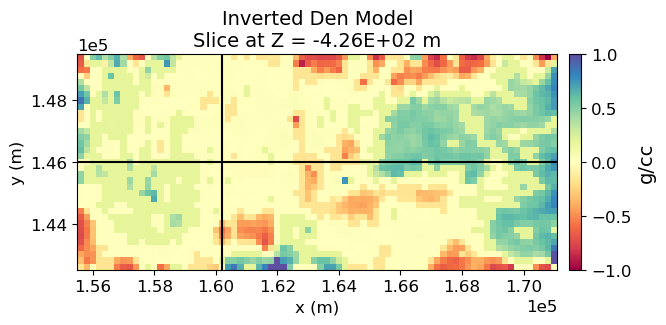

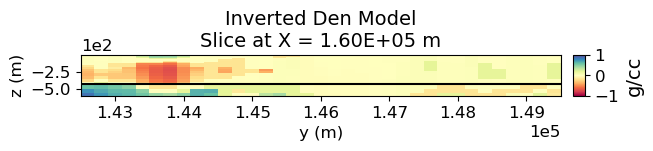

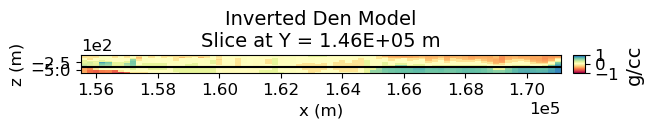

In [119]:
set = 1
save_plots = True

# Indices of the depth sections
ind_plot_x = int(len(inv_mesh.cell_centers_x)/6) + 10
ind_plot_y = int(len(inv_mesh.cell_centers_y)/2)
ind_plot_z = int(len(inv_mesh.cell_centers_z)/2) - 17

ind_plot = [ind_plot_x, ind_plot_y, ind_plot_z]

# Extract the results
inverted_density_model = density_map * inverted_model
quasi_geology_model = actvMap * regularization_term.objfcts[0].compute_quasi_geology_model()

# Plot Density Contrast Model (Z)
normal = "Z"
model_to_plot = inverted_density_model
SH.plot_model_slice(inv_mesh, actv, model_to_plot, normal, ind_plot, [-1, 1], set, sec_loc=True, gdlines=True, which_prop="Den", cmap="Spectral", save_plt=save_plots, path_to_output=path_to_output, name=name)

# Plot Inverted Model Slices (Y)
normal = "X"
model_to_plot = inverted_density_model
SH.plot_model_slice(inv_mesh, actv, model_to_plot, normal, ind_plot, [-1, 1], set, sec_loc=True, gdlines=True, which_prop="Den", cmap="Spectral", save_plt=save_plots, path_to_output=path_to_output, name=name)

# Plot Inverted Model Slices (X)
normal = "Y"
model_to_plot = inverted_density_model
SH.plot_model_slice(inv_mesh, actv, model_to_plot, normal, ind_plot, [-1, 1], set, sec_loc=True, gdlines=True, which_prop="Den", cmap="Spectral", save_plt=save_plots, path_to_output=path_to_output, name=name)

<Figure size 600x600 with 0 Axes>

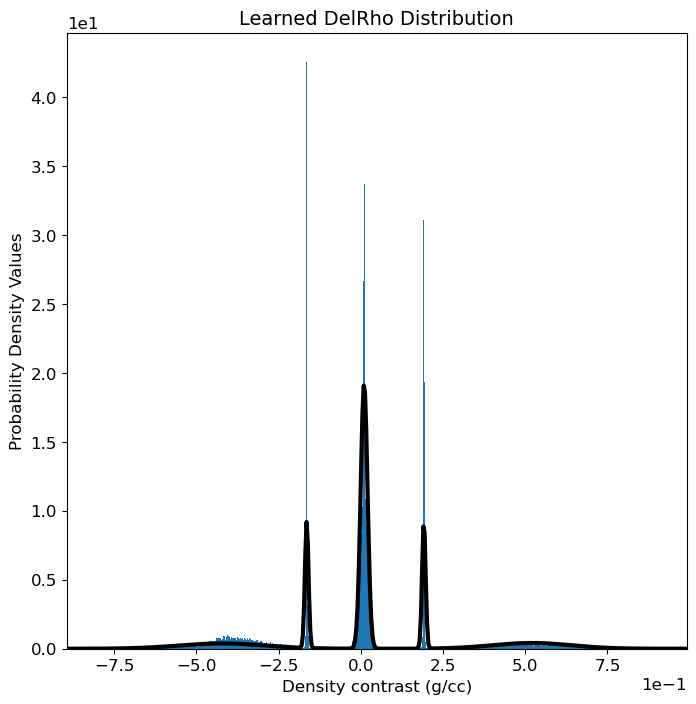

In [115]:
# Updated GMM Parameters
learned_mu = regularization_term.objfcts[0].gmm.means_.flatten()
learned_sigma = regularization_term.objfcts[0].gmm.covariances_.flatten()
learned_pi = regularization_term.objfcts[0].gmm.weights_[0].flatten()

# Regularization Parameters
final_alpha_pgi = regularization_term.alpha_pgi

# Plot the learned GMM
fig = plt.figure(figsize=(6,6))
ax = regularization_term.objfcts[0].gmm.plot_pdf(flag2d=False, plotting_precision=500, padding=0.5)
ax[0].hist(inverted_density_model[actv], density=True, bins=1000)
ax[0].set_xlabel(r"Density contrast (g/cc)")
ax[0].set_ylabel(r"Probability Density Values")
ax[0].get_legend().remove()
ax[0].set_title(r"Learned DelRho Distribution")
ax[0].ticklabel_format(axis="both", style="scientific", scilimits=(0, 0))
plt.savefig(path_to_output + "/" + name + "_Learned_GMM.pdf", bbox_inches="tight")
plt.show()